In [2]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import json
from prophet.serialize import model_to_json

# Налаштування візуалізацій
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (18, 8)

# Завантажуємо фінальний датасет
data_path = '../data/dataset_for_modeling.csv'
df = pd.read_csv(data_path, index_col='DateTime', parse_dates=True)

# Агрегуємо до денного рівня
df_daily = df['Global_active_power'].resample('D').sum()

print("Денні дані для моделі Prophet готові. Розмір:", df_daily.shape)

Денні дані для моделі Prophet готові. Розмір: (1434,)


In [3]:
# Готуємо дані
df_prophet = df_daily.reset_index()
df_prophet.rename(columns={'DateTime': 'ds', 'Global_active_power': 'y'}, inplace=True)

# Розділяємо на тренувальний та тестовий набори (так само, як для SARIMA)
train_df_prophet = df_prophet[df_prophet['ds'] <= '2009-12-31']
test_df_prophet = df_prophet[df_prophet['ds'] > '2009-12-31']

print(f"Розмір тренувального набору: {len(train_df_prophet)}")
print(f"Розмір тестового набору: {len(test_df_prophet)}")

display(train_df_prophet.head())

Розмір тренувального набору: 1104
Розмір тестового набору: 330


,ds,y
0,2006-12-24,111.094
1,2006-12-25,1040.112
2,2006-12-26,251.424
3,2006-12-27,0.000
4,2006-12-28,529.246


In [4]:
# Створюємо та навчаємо модель
# daily_seasonality=False, бо ми працюємо з денними даними
model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

# Prophet може автоматично враховувати свята для конкретної країни
model_prophet.add_country_holidays(country_name='FR') # FR - Франція

# Навчаємо модель
model_prophet.fit(train_df_prophet)

print("Модель Prophet успішно навчена.")

20:23:50 - cmdstanpy - INFO - Chain [1] start processing
20:23:51 - cmdstanpy - INFO - Chain [1] done processing


Модель Prophet успішно навчена.


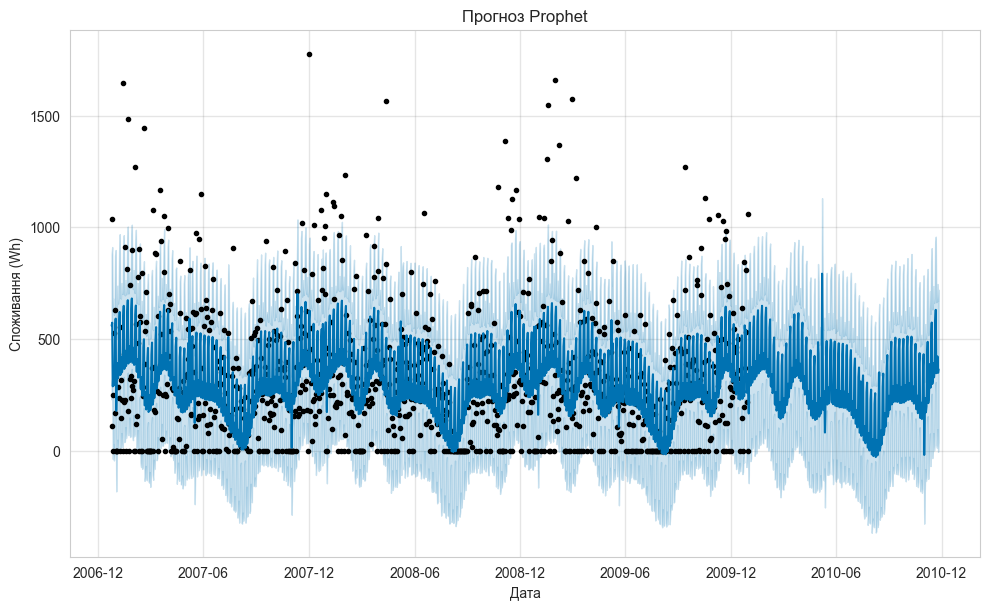

Mean Absolute Error (MAE): 176.69
Root Mean Squared Error (RMSE): 226.62


In [5]:
# Створюємо DataFrame для майбутніх дат
future = model_prophet.make_future_dataframe(periods=len(test_df_prophet), freq='D')

# Робимо прогноз
forecast = model_prophet.predict(future)

# Візуалізуємо результат
fig = model_prophet.plot(forecast)
plt.title('Прогноз Prophet')
plt.xlabel('Дата')
plt.ylabel('Споживання (Wh)')
plt.show()

# Оцінка точності
# Вибираємо прогнози, що відповідають тестовому періоду
predictions_prophet = forecast.set_index('ds').loc['2010-01-01':]['yhat']
actuals = test_df_prophet.set_index('ds')['y']

mae = mean_absolute_error(actuals, predictions_prophet)
rmse = np.sqrt(mean_squared_error(actuals, predictions_prophet))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

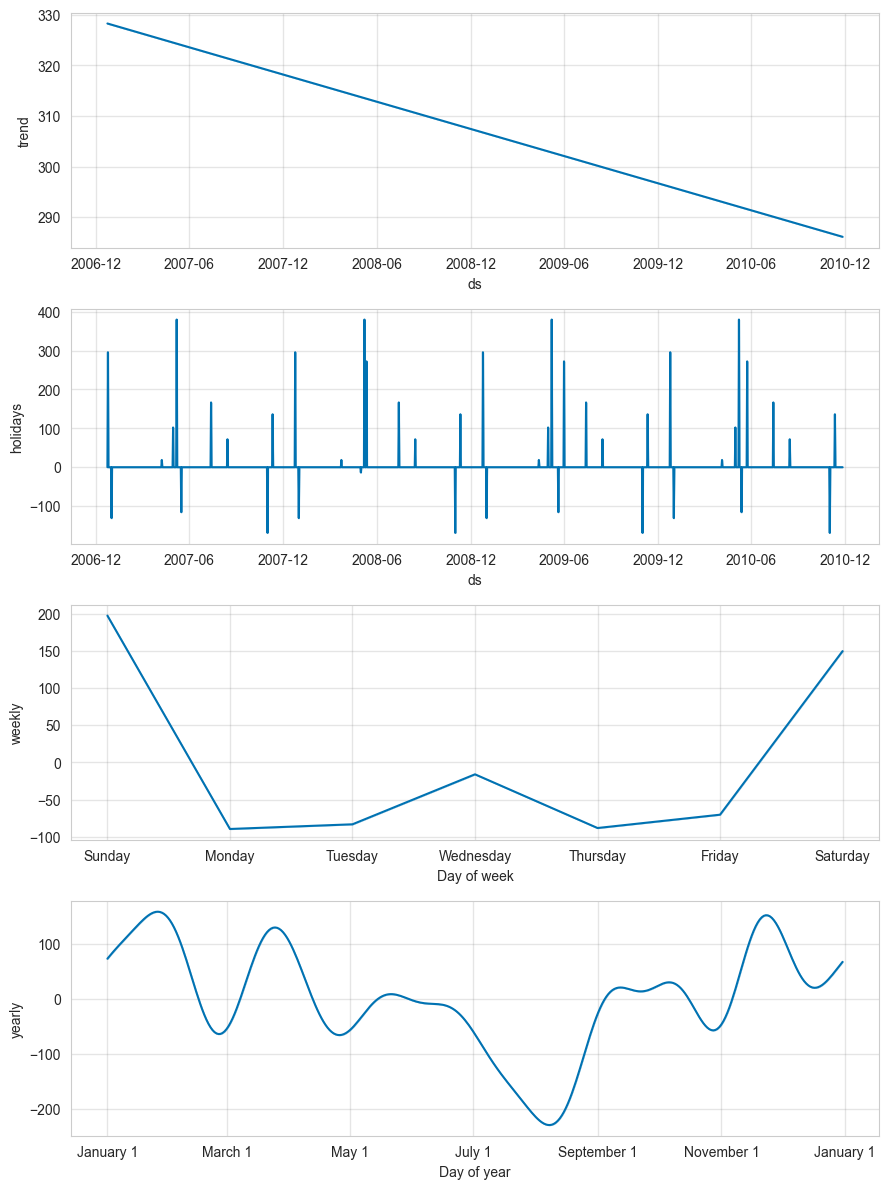

In [6]:
# Візуалізація компонентів прогнозу
fig_components = model_prophet.plot_components(forecast)
plt.show()

In [7]:
# Моделі Prophet зберігаються у форматі JSON
model_path = '../models/prophet_baseline_model.json'
with open(model_path, 'w') as fout:
    json.dump(model_to_json(model_prophet), fout)

print(f"Модель Prophet успішно збережено в: {model_path}")

Модель Prophet успішно збережено в: ../models/prophet_baseline_model.json
